In [58]:
%env CUDA_VISIBLE_DEVICES=1
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
# from wandb.apis.importers.mlflow import MlflowImporter
import wandb
api = wandb.Api()

env: CUDA_VISIBLE_DEVICES=1


In [116]:
import json
data = json.load(open('summary.json'))
data = {
    k: {
        "ckpt": jnp.array([vi[2] for vi in v]),
        "tflops": jnp.array([vi[3] for vi in v]),
        "fid": jnp.array([vi[4] for vi in v]),
    }
    for k, v in data.items()
}

# Filter out some data
print(data["TTT-B-pixel"])
print({k: v.shape for k, v in data["TTT-B-pixel"].items()})
mask = data["TTT-B-pixel"]["ckpt"] != 300000
print(mask)
data["TTT-B-pixel"] = {
    "ckpt": data["TTT-B-pixel"]["ckpt"][mask],
    "tflops": data["TTT-B-pixel"]["tflops"][mask],
    "fid": data["TTT-B-pixel"]["fid"][mask],
}
print({k: v.shape for k, v in data["TTT-B-pixel"].items()})

# Filter out XL
data = {k: v for k, v in data.items() if "XL" not in k}
data

{'ckpt': Array([100000, 150000, 200000, 250000, 300000, 350000, 399999], dtype=int32), 'tflops': Array([5.7139904e+08, 8.5709856e+08, 1.1427981e+09, 1.4284975e+09,
       1.7141971e+09, 1.9998966e+09, 2.2855903e+09], dtype=float32), 'fid': Array([91.291595, 75.97905 , 68.51304 , 58.60682 , 62.098255, 52.740383,
       49.042683], dtype=float32)}
{'ckpt': (7,), 'tflops': (7,), 'fid': (7,)}
[ True  True  True  True False  True  True]
{'ckpt': (6,), 'tflops': (6,), 'fid': (6,)}


{'DiT-S-latent': {'ckpt': Array([100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000],      dtype=int32),
  'tflops': Array([ 4832570.5,  9665141. , 14497712. , 19330282. , 24162854. ,
         28995424. , 33827996. , 38660564. ], dtype=float32),
  'fid': Array([83.27027 , 65.008286, 56.33017 , 50.936802, 46.850136, 46.09369 ,
         43.590485, 42.610695], dtype=float32)},
 'DiT-B-latent': {'ckpt': Array([100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000,
         500000, 550000, 600000, 650000, 700000], dtype=int32),
  'tflops': Array([1.6348164e+07, 2.4522246e+07, 3.2696328e+07, 4.0870412e+07,
         4.9044492e+07, 5.7218576e+07, 6.5392656e+07, 7.3566736e+07,
         8.1740824e+07, 8.9914904e+07, 9.8088984e+07, 1.0626307e+08,
         1.1443715e+08], dtype=float32),
  'fid': Array([58.25228 , 46.034046, 40.357754, 36.358753, 34.5927  , 31.911104,
         29.868193, 29.382275, 27.847406, 27.58652 , 26.78144 , 26.629776,
         25.615072], dtype=float32)

In [117]:
print(data.keys())
print(data["TTT-B-pixel"])

dict_keys(['DiT-S-latent', 'DiT-B-latent', 'DiT-L-latent', 'SSM-Ti-latent', 'SSM-S-latent', 'SSM-B-latent', 'SSM-L-latent', 'TTT-Ti-pixel', 'TTT-S-pixel', 'TTT-B-pixel', 'TTT-L-pixel'])
{'ckpt': Array([100000, 150000, 200000, 250000, 350000, 399999], dtype=int32), 'tflops': Array([5.7139904e+08, 8.5709856e+08, 1.1427981e+09, 1.4284975e+09,
       1.9998966e+09, 2.2855903e+09], dtype=float32), 'fid': Array([91.291595, 75.97905 , 68.51304 , 58.60682 , 52.740383, 49.042683],      dtype=float32)}


# Visualize Data

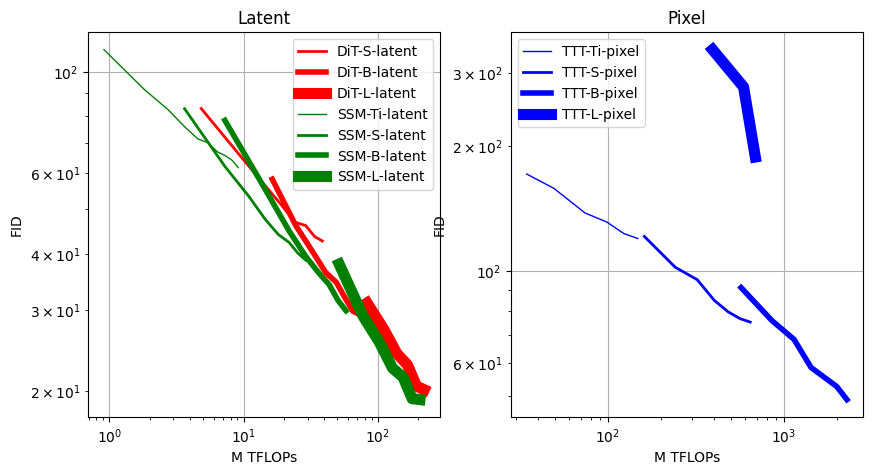

In [118]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for k, v in data.items():
    if 'latent' in k:
        i = 0
    else: 
        i = 1

    if 'DiT' in k: linecolor = 'r'
    elif 'SSM' in k: linecolor = 'g'
    elif 'TTT' in k: linecolor = 'b'
    else: raise NotImplemented
   
    if "-Ti-"  in k:
        linewidth = 1
    elif "-S-" in k:
        linewidth = 2
    elif "-B-" in k:
        linewidth = 4
    elif "-L-" in k:
        linewidth = 8
    elif "-XL-" in k:
        linewidth = 10
    else:
        raise ValueError(k) 
    
    axs[i].plot(
        v['tflops']/1e6, v['fid'], 
        color=linecolor, linewidth=linewidth, label=k)
    
axs[0].set_title("Latent")
axs[1].set_title("Pixel")

for i in range(2):
    axs[i].legend()
    axs[i].set_xlabel('M TFLOPs')
    axs[i].set_ylabel('FID')
    # axs[i].set_ylim(0, 140)
    axs[i].set_yscale("log")
    axs[i].set_xscale("log")
    axs[i].grid()
plt.show()

# Fitting Scaling Law for each Model Class

## Simple Method

[100000 150000 200000 250000 350000 399999] [11.512925 11.91839  12.206073 12.429216 12.765689 12.899218]
[[-0.44800833]] [9.6721325]
[91.291595 75.97905  68.51304  58.60682  52.740383 49.042683] [4.5140586 4.3304577 4.227024  4.070851  3.9653814 3.8926911]


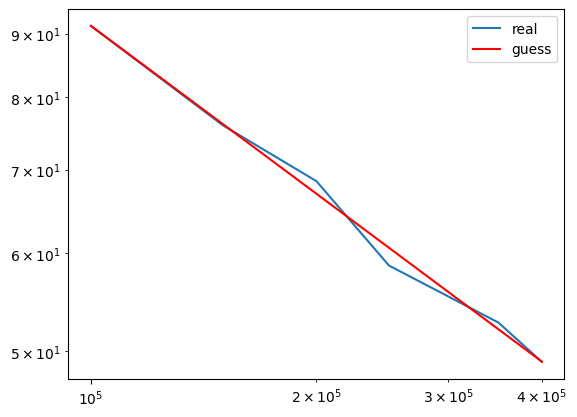

In [119]:
from sklearn.linear_model import LinearRegression


ex_run_data = data["TTT-B-pixel"]
xs = jnp.array(ex_run_data["ckpt"])
log_xs = jnp.log(xs)
print(xs, log_xs)
ys = ex_run_data["fid"]
log_ys = jnp.log(ys)

# Fit Linear Regression
reg = LinearRegression().fit(log_xs.reshape(-1, 1), log_ys.reshape(-1, 1))
print(reg.coef_, reg.intercept_)
def guess(x):
    a = jnp.exp(reg.intercept_)
    alpha = reg.coef_[0][0]
    return a * x ** alpha 
ys_ = guess(xs)

print(ys, log_ys)
plt.figure()
plt.plot(xs, ys, label='real')    
plt.plot(xs, ys_, 'r', label='guess')   
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


[[-0.28918833]] [10.2033825]
[171.38432  158.28143  138.15182  131.29578  123.1746   119.84617
 121.2548   102.16781   95.37178   85.04063   79.7909    76.85564
  75.40089   91.291595  75.97905   68.51304   58.60682   52.740383
  49.042683] [5.1439085 5.064375  4.9283533 4.877453  4.813603  4.786209  4.797894
 4.6266165 4.5577826 4.443129  4.3794093 4.341929  4.322819  4.5140586
 4.3304577 4.227024  4.070851  3.9653814 3.8926911]


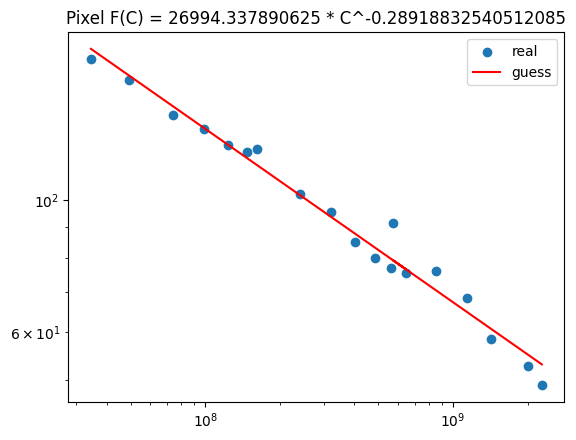

In [63]:
from sklearn.linear_model import LinearRegression

xs, ys = [], []
for k, v in data.items():
    # if "TTT" not in k or "L" in k or "Ti" in k or "S" in k:
    #     continue
    if "TTT" not in k or "L" in k:
        continue
    xs.extend(list(v['tflops']))
    ys.extend(list(v['fid']))
    
xs = jnp.array(xs)
log_xs = jnp.log(xs)
ys = jnp.array(ys)
log_ys = jnp.log(ys)

# Fit Linear Regression
reg = LinearRegression().fit(log_xs.reshape(-1, 1), log_ys.reshape(-1, 1))
print(reg.coef_, reg.intercept_)
def guess(x):
    a = jnp.exp(reg.intercept_[0])
    alpha = reg.coef_[0][0]
    return a * x ** alpha 
ys_ = guess(xs)

print(ys, log_ys)
plt.figure()
plt.title(f"Pixel F(C) = {jnp.exp(reg.intercept_[0])} * C^{reg.coef_[0][0]}")
plt.scatter(xs, ys, label='real')    
plt.plot(xs, ys_, 'r', label='guess')   
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()



[[-0.383461]] [10.362148]
[83.27027  65.008286 56.33017  50.936802 46.850136 46.09369  43.590485
 42.610695 58.25228  46.034046 40.357754 36.358753 34.5927   31.911104
 29.868193 29.382275 27.847406 27.58652  26.78144  26.629776 25.615072
 31.164175 27.251863 24.127438 22.784208 20.463795 20.091518] [4.4220915 4.174515  4.0312304 3.9305856 3.8469539 3.830676  3.774839
 3.7521052 4.064783  3.8293812 3.6977835 3.593435  3.5436428 3.462954
 3.396794  3.3803916 3.3267398 3.3173273 3.2877092 3.28203   3.243181
 3.4392693 3.305122  3.1833496 3.1260676 3.0186572 3.0002978]


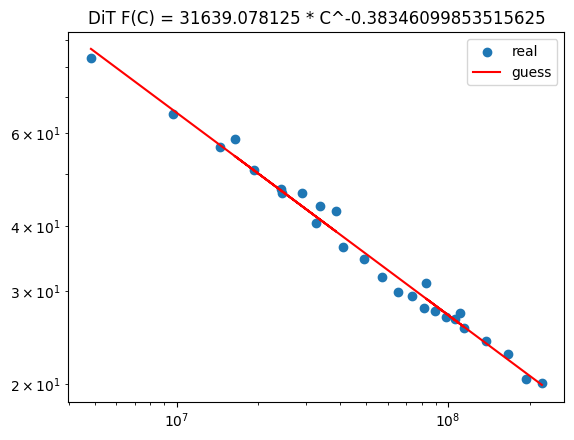

In [64]:
from sklearn.linear_model import LinearRegression

xs, ys = [], []
for k, v in data.items():
    if "DiT" not in k or "XL" in k:
        continue
    xs.extend(list(v['tflops']))
    ys.extend(list(v['fid']))
    
xs = jnp.array(xs)
log_xs = jnp.log(xs)
ys = jnp.array(ys)
log_ys = jnp.log(ys)

# Fit Linear Regression
reg = LinearRegression().fit(log_xs.reshape(-1, 1), log_ys.reshape(-1, 1))
print(reg.coef_, reg.intercept_)
def guess(x):
    a = jnp.exp(reg.intercept_[0])
    alpha = reg.coef_[0][0]
    return a * x ** alpha 
ys_ = guess(xs)

print(ys, log_ys)
plt.figure()
plt.title(f"DiT F(C) = {jnp.exp(reg.intercept_[0])} * C^{reg.coef_[0][0]}")
plt.scatter(xs, ys, label='real')    
plt.plot(xs, ys_, 'r', label='guess')   
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()



[[-0.33999854]] [9.511089]
[112.17536   91.670235  82.83886   75.90221   71.45185   69.965576
  66.90913   65.64094   64.12715   61.801777  83.18959   62.119133
  53.497917  47.513832  44.037014  42.332977  40.06324   38.68463
  78.43959   55.32726   44.926025  39.433983  36.298626  34.159176
  31.499523  29.957876  37.923424  29.224056  25.52191   22.409962
  21.393856  19.197815  19.109545] [4.720063  4.5181975 4.4168973 4.329446  4.269024  4.2480035 4.2033353
 4.1841993 4.1608677 4.1239324 4.421122  4.129054  3.9796426 3.8610208
 3.7850306 3.7455664 3.6904593 3.6554425 4.362329  4.0132656 3.8050172
 3.674628  3.59178   3.5310311 3.4499724 3.3997922 3.635569  3.3749921
 3.2395372 3.1095057 3.0631037 2.9547966 2.950188 ]


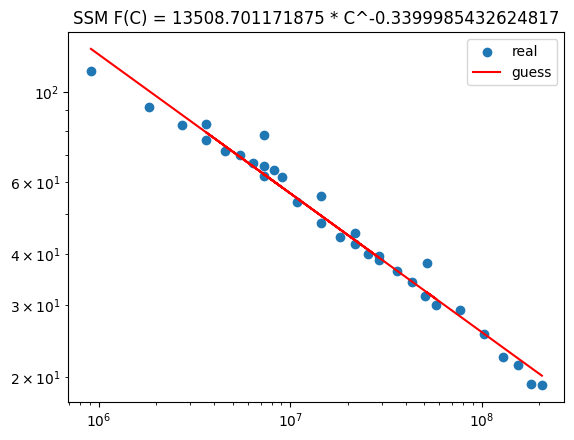

In [65]:

from sklearn.linear_model import LinearRegression

xs, ys = [], []
for k, v in data.items():
    if "SSM" not in k or "XL" in k:
        continue
    xs.extend(list(v['tflops']))
    ys.extend(list(v['fid']))
    
xs = jnp.array(xs)
log_xs = jnp.log(xs)
ys = jnp.array(ys)
log_ys = jnp.log(ys)

# Fit Linear Regression
reg = LinearRegression().fit(log_xs.reshape(-1, 1), log_ys.reshape(-1, 1))
print(reg.coef_, reg.intercept_)
def guess(x):
    a = jnp.exp(reg.intercept_[0])
    alpha = reg.coef_[0][0]
    return a * x ** alpha 
ys_ = guess(xs)

print(ys, log_ys)
plt.figure()
plt.title(f"SSM F(C) = {jnp.exp(reg.intercept_[0])} * C^{reg.coef_[0][0]}")
plt.scatter(xs, ys, label='real')    
plt.plot(xs, ys_, 'r', label='guess')   
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()



# My Method

[[-0.44800833]] [9.6721325]
{'params': {'scale': Array([9.6721325], dtype=float32), 'l_inf': Array([0.], dtype=float32), 'alpha': Array([-0.80294347], dtype=float32)}} FIDModel(
    # attributes
    unit = 1
    offset = 0
    scale_init = array([9.6721325], dtype=float32)
    alpha_init = Array(-0.80294347, dtype=float32)
    l_inf_init = 0.0
) [15870.153]


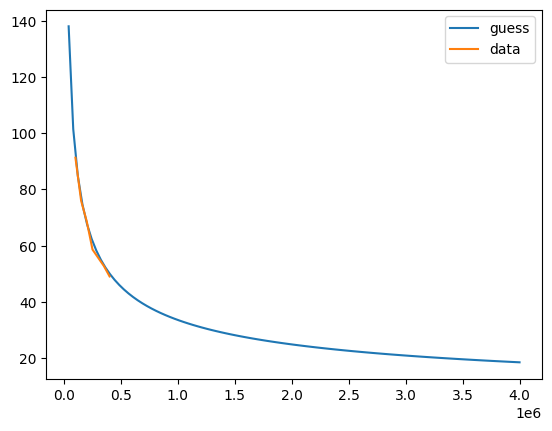

In [66]:
import jax.numpy as jnp
import jax
import flax.linen as nn

class FIDModel(nn.Module):
    unit: float = 1
    offset: float = 0
    
    scale_init: float = 0.
    alpha_init: float = 0.
    l_inf_init: float = 0. # small value
    
    @nn.compact
    def __call__(self, x):
        x = x / self.unit + self.offset
        scale = self.param('scale', nn.initializers.constant(self.scale_init), (1,))
        l_inf = self.param('l_inf', nn.initializers.constant(self.l_inf_init), (1,))
        alpha = self.param('alpha', nn.initializers.constant(self.alpha_init), (1,))
        return jnp.exp(scale) * x  ** (-jnp.exp(alpha)) + jnp.exp(l_inf)
  
key = "TTT-B-pixel" 
xs, ys = data[key]["ckpt"], data[key]["fid"]
reg = LinearRegression().fit(jnp.log(xs).reshape(-1, 1), jnp.log(ys).reshape(-1, 1))
print(reg.coef_, reg.intercept_)

model = FIDModel(
    alpha_init=jnp.log(-reg.coef_[0][0]),
    scale_init=reg.intercept_, 
)
params = model.init(jax.random.PRNGKey(0), jnp.array([1.0]))
out = model.apply(params, jnp.array([1.0]))
print(params, model, out)

xs_ = jnp.linspace(0, xs.max() * 10, 100)
ys_ = model.apply(params, xs_)
plt.plot(xs_, ys_, label="guess")
plt.plot(xs, ys, label="data")
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

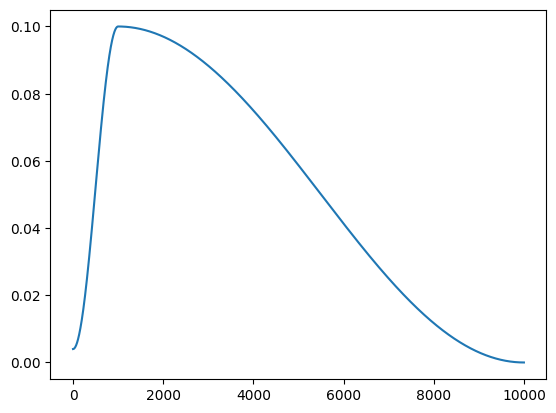

In [67]:
import optax
niters = 10_000
lr = 0.1
lr_sch = optax.schedules.cosine_onecycle_schedule(niters, peak_value=lr, pct_start=0.1)

xs = np.arange(niters)
ys = [lr_sch(xs[i]) for i in range(niters)]
plt.plot(xs, ys)

(13,) (13,)
[[-0.40704748]] [8.687253]
(Before) Objective function:  0.0019585409
Iteration 0, loss=0.0009533096454106271 params={'params': {'alpha': Array([-0.8948251], dtype=float32), 'l_inf': Array([-0.00399996], dtype=float32), 'scale': Array([8.683249], dtype=float32)}} lr=0.0040000006556510925
Iteration 10000, loss=0.00030656257877126336 params={'params': {'alpha': Array([-0.216573], dtype=float32), 'l_inf': Array([2.841665], dtype=float32), 'scale': Array([12.946868], dtype=float32)}} lr=0.10000000149011612
Iteration 20000, loss=0.0005778179620392621 params={'params': {'alpha': Array([-0.18340692], dtype=float32), 'l_inf': Array([2.8714392], dtype=float32), 'scale': Array([13.235238], dtype=float32)}} lr=0.09698464721441269
Iteration 30000, loss=0.00019602868997026235 params={'params': {'alpha': Array([-0.18672876], dtype=float32), 'l_inf': Array([2.8782072], dtype=float32), 'scale': Array([13.260478], dtype=float32)}} lr=0.08830226957798004
Iteration 40000, loss=0.0002391870366

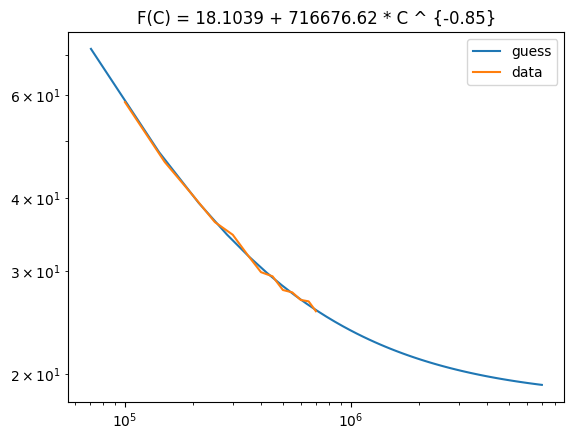

In [77]:
import optax
import jax
import jax.numpy as jnp

def create_fid_model(xs, ys, niters=100_000, eps=1e-6, lr=0.1, verbose=True):
  # estimate the rough parameters
  
  reg = LinearRegression().fit(
    jnp.log(xs).reshape(-1, 1), jnp.log(ys).reshape(-1, 1))
  print(reg.coef_, reg.intercept_)
  fid_model = FIDModel(
    alpha_init=jnp.log(-reg.coef_[0][0]),
    scale_init=reg.intercept_, 
  )
  params = fid_model.init(jax.random.PRNGKey(0), jnp.array([1.0]))

  def loss(params):
    y_ = fid_model.apply(params, xs)
    # return jnp.mean(jnp.square(ys - y_))
    return jnp.mean(jnp.square(ys - y_) / (jnp.square(ys) + eps))
  
  @jax.jit 
  def step(params, opt_state):
    value, grad = jax.value_and_grad(loss)(params)
    updates, opt_state = solver.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value
  print('(Before) Objective function: ', loss(params))

  # lr_sch = lambda t: lr * 0.5 ** jnp.floor(t / float(interval))
  lr_sch = optax.schedules.cosine_onecycle_schedule(
    niters, peak_value=lr, pct_start=0.1)
  interval = niters // 10
  solver = optax.adamw(lr_sch)
  opt_state = solver.init(params)
  for i in range(niters):
    params, opt_state, _ = step(params, opt_state)
    if i % interval == 0:
      value = loss(params)
      if verbose:
        print(f'Iteration {i}, loss={value} params={params} lr={lr_sch(i)}')
  print('(Final) Objective function: ', loss(params))
  eq = "F(C) = %.4f + %.2f * C ^ {%.2f}" % (
    float(jnp.exp(params["params"]["l_inf"][0])), 
    float(jnp.exp(params["params"]["scale"][0])), 
    float(-jnp.exp(params["params"]["alpha"][0])))
  print("Equation: %s"  % eq)
  return params, fid_model, eq

# key = "TTT-Ti-pixel" 
key = "DiT-B-latent" 
xs, ys = data[key]["ckpt"], data[key]["fid"]
print(xs.shape, ys.shape)
params, fid_model, eq = create_fid_model(xs, ys)

xs_ = jnp.linspace(0, xs.max() * 10, 100)
ys_ = model.apply(params, xs_)
plt.plot(xs_, ys_, label="guess")
plt.plot(xs, ys, label="data")
plt.title(eq)
plt.xscale('log')
plt.yscale('log')
plt.legend()

Shape (6,) (6,)
[[-0.44800833]] [9.6721325]
(Before) Objective function:  0.00057662796
Iteration 0, loss=0.00039599393494427204 params={'params': {'alpha': Array([-0.79894316], dtype=float32), 'l_inf': Array([-0.0039999], dtype=float32), 'scale': Array([9.668129], dtype=float32)}} lr=0.0040000006556510925
Iteration 10000, loss=0.00033722672378644347 params={'params': {'alpha': Array([-0.7941354], dtype=float32), 'l_inf': Array([-0.01953378], dtype=float32), 'scale': Array([9.710765], dtype=float32)}} lr=0.10000000149011612
Iteration 20000, loss=0.00032144159195013344 params={'params': {'alpha': Array([-0.8025287], dtype=float32), 'l_inf': Array([-0.6571552], dtype=float32), 'scale': Array([9.670044], dtype=float32)}} lr=0.09698464721441269
Iteration 30000, loss=0.0003765213186852634 params={'params': {'alpha': Array([-0.8061438], dtype=float32), 'l_inf': Array([-1.1933674], dtype=float32), 'scale': Array([9.657827], dtype=float32)}} lr=0.08830226957798004
Iteration 40000, loss=0.00030

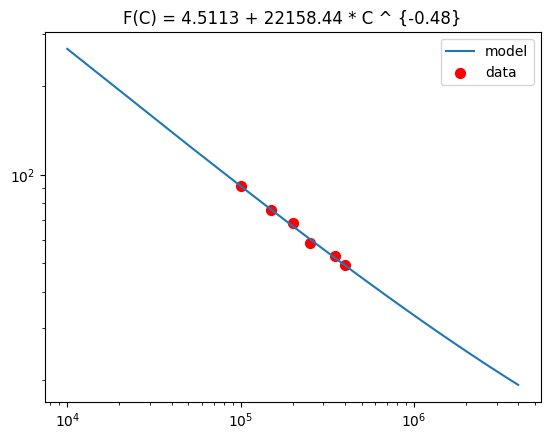

In [86]:
# TODO: filter the array to remove the NaN values
def make_data(k):
    xs = np.array(data[k]["ckpt"])
    idxs = []
    for i in range(xs.shape[0]):
        if jnp.any(jnp.isnan(xs[i])): continue
        if xs[i] < 50000: continue
        idxs.append(i)
    xs = xs[idxs] 
    ys = np.array(data[k]["fid"])
    ys = ys[idxs]
    zs = np.array(data[k]["tflops"])
    zs = zs[idxs]
    return xs, ys, zs

# xs, ys, _ = make_data("DiT-B-latent")
xs, ys, _ = make_data("TTT-B-pixel")
print("Shape", xs.shape, ys.shape)

params, fid_model, eq = create_fid_model(xs, ys, niters=100_000, lr=0.1)
xs_ = jnp.linspace(10000, xs.max() * 10, 100)
ys_ = fid_model.apply(params, xs_)
mse = jnp.mean(jnp.square(
    ys.reshape(-1)[10:] - fid_model.apply(params, xs).reshape(-1)[10:]))
print("MSE:", mse)
plt.plot(xs_, ys_, label="model")
plt.scatter(xs, ys, label="data", s=50, c="r")
plt.title(eq)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
xs, ys, _ = make_data("TTT-B-pixel")
print("Shape", xs.shape, ys.shape)

for split_idx in range(3, xs.shape[0] - 1):
    params, fid_model, eq = create_fid_model(xs[:split_idx], ys[:split_idx], niters=1_000_000, lr=0.1)
    xs_ = jnp.linspace(10000, xs.max() * 10, 100)
    ys_ = fid_model.apply(params, xs_)
    mse = jnp.mean(jnp.square(
        ys.reshape(-1)[split_idx:] - 
        fid_model.apply(params, xs).reshape(-1)[split_idx:]))
    print("MSE:", mse)
    plt.plot(xs_, ys_, label="model")
    plt.scatter(xs[split_idx:], ys[split_idx:], label="data(te)", s=50, c="r")
    plt.scatter(xs[:split_idx], ys[:split_idx], label="data(tr)", s=50, c="g")
    plt.title("%s\n mse=%e" % (eq, mse))
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

# Fitting data

In [240]:
model_type = "DiT"
# model_type = "TTT"
# model_type = "SSM"
# exclude_type = "XL"
scaling_data = {}
max_flops = 0
fid_models = {}
for name in data.keys():
    if model_type not in name:
        continue
    # if exclude_type in name:
    #     continue
    print(name)
    xs, ys, zs = make_data(name)
    if len(xs) == 0:
        continue    
    params, fid_model, eq = create_fid_model(xs, ys)
    print(eq)
    flops_per_iter = data[name]["tflops"][0] / float(data[name]["ckpt"][0])
    max_flops = max(max_flops, flops_per_iter * 400_000)
    
    fid_models[name] = {
        "params": params,
        "fid_model": fid_model,
        "eq": eq,
        "xs": xs,
        "ys": ys,
        "zs": zs,
        "flops_per_iter": flops_per_iter,
    }
   

DiT-S-latent
[[-0.32630834]] [8.159685]
(Before) Objective function:  0.00075464835
Iteration 0, loss=0.0003569655818864703 params={'params': {'alpha': Array([-1.1159121], dtype=float32), 'l_inf': Array([-0.00399992], dtype=float32), 'scale': Array([8.155682], dtype=float32)}} lr=0.0040000006556510925
Iteration 10000, loss=0.00027501850854605436 params={'params': {'alpha': Array([-0.6223565], dtype=float32), 'l_inf': Array([3.1125798], dtype=float32), 'scale': Array([10.304147], dtype=float32)}} lr=0.10000000149011612
Iteration 20000, loss=0.00014457634824793786 params={'params': {'alpha': Array([-0.599801], dtype=float32), 'l_inf': Array([3.128259], dtype=float32), 'scale': Array([10.416776], dtype=float32)}} lr=0.09698464721441269
Iteration 30000, loss=0.00015296743367798626 params={'params': {'alpha': Array([-0.6007164], dtype=float32), 'l_inf': Array([3.1341894], dtype=float32), 'scale': Array([10.425822], dtype=float32)}} lr=0.08830226957798004
Iteration 40000, loss=0.000232199905

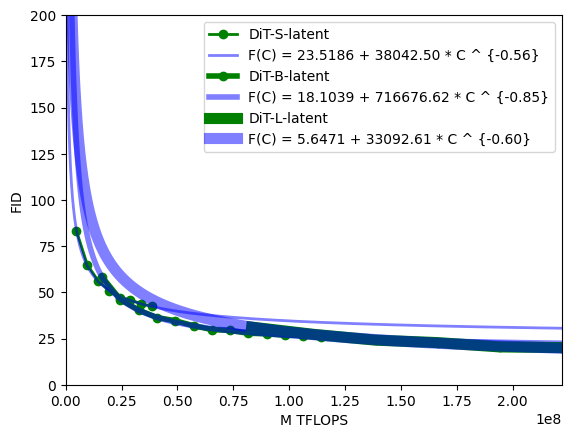

In [241]:
for name, model_info in fid_models.items(): 
    match name.split("-")[1]:
        case 'Ti':  linewidth = 1
        case 'S':   linewidth = 2
        case 'B':   linewidth = 4
        case _:     linewidth = 8
        
    xs_ = jnp.linspace(1, max_flops , 10_000)
    ys_ = model_info["fid_model"].apply(
        model_info["params"], xs_ / model_info["flops_per_iter"])
    
    plt.plot(
        model_info["zs"], model_info["ys"],  c="g", label=name, 
        linewidth=linewidth, marker="o")
    plt.plot(
        xs_, ys_, c="b", label=model_info["eq"], linewidth=linewidth, 
        alpha=0.5)
    plt.xlabel("M TFLOPS")
    plt.ylabel("FID")
    plt.xlim(0, max_flops)
    plt.ylim(0, 200)
    # plt.xscale("log")
    # plt.yscale("log")
    
    scaling_data[name] = {
        "eq": model_info["eq"],
        "params": model_info["params"],
        "fid_model": model_info["fid_model"],
        "flops_per_iter": model_info["flops_per_iter"],
        "flops_est": xs_, "fid_est": ys_,
        "flops_orig": model_info["zs"],
        "fid_orig": model_info["ys"],
        "step_orig": model_info["xs"],
    }
plt.legend()

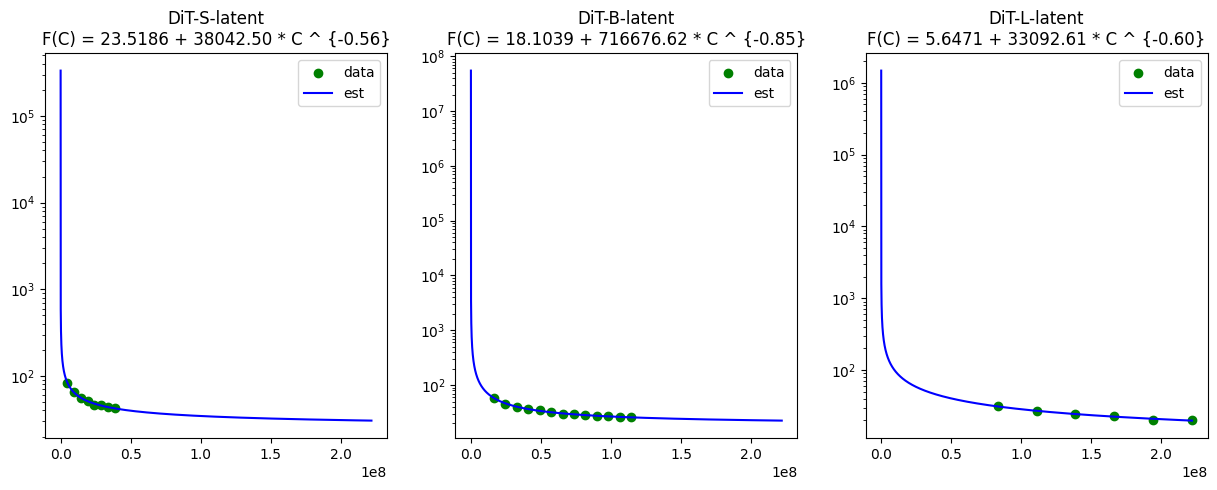

In [242]:
l = len(scaling_data)
i = 0
plt.figure(figsize=(5 * l, 5))
for name, scale_info in scaling_data.items():
    i += 1
    plt.subplot(1, l, i)
    plt.title("%s\n%s" % (name, scale_info["eq"]))
    plt.scatter(scale_info["flops_orig"], scale_info["fid_orig"], label="data", c="g")
    plt.plot(scale_info["flops_est"], scale_info["fid_est"], label="est", c="b")
    # plt.xlim(scale_info["flops_orig"].min(), max_flops)
    # plt.xlim(1e7, max_flops)
    # plt.xscale("log")
    plt.yscale("log")
    plt.legend()
plt.show()

# Compute the Scaling Property

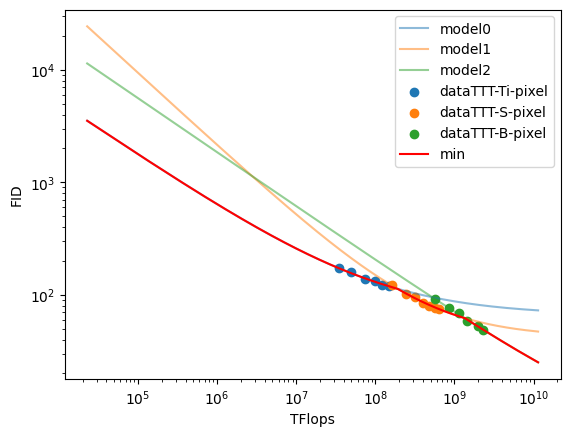

In [171]:
def min_flop_to_fid_curve(scaling_data, flops):
    ys_lst = []
    for name, data in scaling_data.items():
        flops_per_iter = data["flops_per_iter"]
        ys_ = data["fid_model"].apply(data["params"], flops / flops_per_iter)
        ys_lst.append(ys_)
    ys_lst = jnp.array(ys_lst)
    return ys_lst

npnts = 100_000
xs_flops = jnp.linspace(max_flops * 1e-5, max_flops * 5, npnts)
ys_lst = min_flop_to_fid_curve(scaling_data, xs_flops)
for i in range(ys_lst.shape[0]):
    plt.plot(xs_flops, ys_lst[i], alpha=0.5, label=f"model{i}")
for name, scale_info in scaling_data.items():
    plt.scatter(
        scale_info["flops_orig"], scale_info["fid_orig"], label=f"data{name}")
plt.plot(xs_flops, ys_lst.min(axis=0), c="r", label="min")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("TFlops")
plt.ylabel("FID")
plt.legend()

In [172]:
def create_lower_bounded_fid_model(xs, ys, niters=100_000, eps=1e-6, lr=0.1, 
                                   verbose=True):
  # estimate the rough parameters
  reg = LinearRegression().fit(
    jnp.log(xs).reshape(-1, 1), jnp.log(ys).reshape(-1, 1))
  print(reg.coef_, reg.intercept_)
  fid_model = FIDModel(
    alpha_init=jnp.log(-reg.coef_[0][0]),
    scale_init=reg.intercept_, 
  )
  params = fid_model.init(jax.random.PRNGKey(0), jnp.array([1.0]))

  def loss(params):
    y_ = fid_model.apply(params, xs)
    rel_mse = jnp.mean(jnp.square(ys - y_) / (jnp.square(ys) + eps))
    mse_gt = jnp.mean(jnp.square(jnp.maximum(y_ - ys, 0)))
    return mse_gt * 0 + rel_mse
  
  @jax.jit 
  def step(params, opt_state):
    value, grad = jax.value_and_grad(loss)(params)
    updates, opt_state = solver.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value
  print('(Before) Objective function: ', loss(params))

  # lr_sch = lambda t: lr * 0.5 ** jnp.floor(t / float(interval))
  lr_sch = optax.schedules.cosine_onecycle_schedule(
    niters, peak_value=lr, pct_start=0.1)
  interval = niters // 10
  solver = optax.adamw(lr_sch)
  opt_state = solver.init(params)
  for i in range(niters):
    params, opt_state, _ = step(params, opt_state)
    if i % interval == 0:
      value = loss(params)
      if verbose:
        print(f'Iteration {i}, loss={value} params={params} lr={lr_sch(i)}')
  print('(Final) Objective function: ', loss(params))
  eq = "F(C) = %.4f + %.2f * C ^ {%.2f}" % (
    float(jnp.exp(params["params"]["l_inf"][0])), 
    float(jnp.exp(params["params"]["scale"][0])), 
    float(-jnp.exp(params["params"]["alpha"][0])))
  print("Equation: %s"  % eq)
  return params, fid_model, eq


In [173]:
xs_flops = jnp.linspace(max_flops * 1e-3, max_flops * 5, npnts)
ys_lst = min_flop_to_fid_curve(scaling_data, xs_flops)
ys = ys_lst.min(axis=0)
s_params, scaling_model, eq = create_lower_bounded_fid_model(xs_flops, ys)
print("$%s$" % eq)

[[-0.37268636]] [11.878763]
(Before) Objective function:  0.0026043323
Iteration 0, loss=0.0016907320823520422 params={'params': {'alpha': Array([-0.98301774], dtype=float32), 'l_inf': Array([-0.00399995], dtype=float32), 'scale': Array([11.874759], dtype=float32)}} lr=0.0040000006556510925
Iteration 10000, loss=0.0019143435638397932 params={'params': {'alpha': Array([-1.0021774], dtype=float32), 'l_inf': Array([-9.88651], dtype=float32), 'scale': Array([11.731448], dtype=float32)}} lr=0.10000000149011612
Iteration 20000, loss=0.0016217229422181845 params={'params': {'alpha': Array([-1.0054017], dtype=float32), 'l_inf': Array([-14.4055395], dtype=float32), 'scale': Array([11.737362], dtype=float32)}} lr=0.09698464721441269
Iteration 30000, loss=0.0056634265929460526 params={'params': {'alpha': Array([-0.99566054], dtype=float32), 'l_inf': Array([-15.802388], dtype=float32), 'scale': Array([11.738661], dtype=float32)}} lr=0.08830226957798004
Iteration 40000, loss=0.0014926709700375795 p

F(C) = 0.0000 + 129565.79 * C ^ {-0.37}


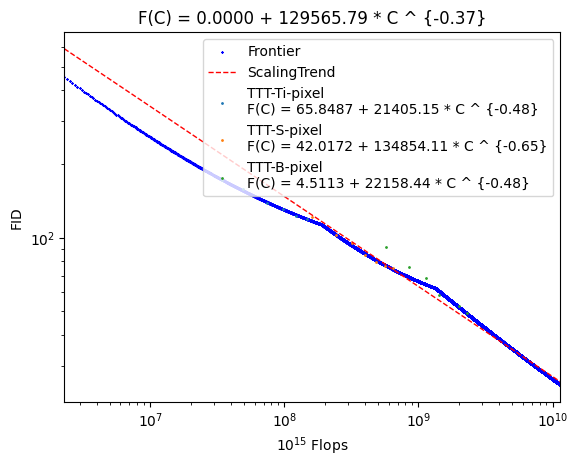

In [174]:
title = eq
print(eq)
plt.title(title)
plt.scatter(xs_flops, ys, c="b", label="Frontier", s=1, marker="x")
plt.plot(
    xs_flops, scaling_model.apply(s_params, xs_flops), 
    c="red", label="ScalingTrend", linewidth=1, linestyle="dashed")
for k, scale_info in scaling_data.items():
    label = "%s\n%s" % (k, scale_info["eq"])
    plt.scatter(scale_info["flops_orig"], scale_info["fid_orig"], 
                label=label, s=1)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("FID")
plt.xlabel("$10^{15}$ Flops")
plt.xlim(xs_flops.min(), xs_flops.max())
plt.legend()
plt.show()


# Final result togeter

DiT-B-latent
TTT-B-pixel


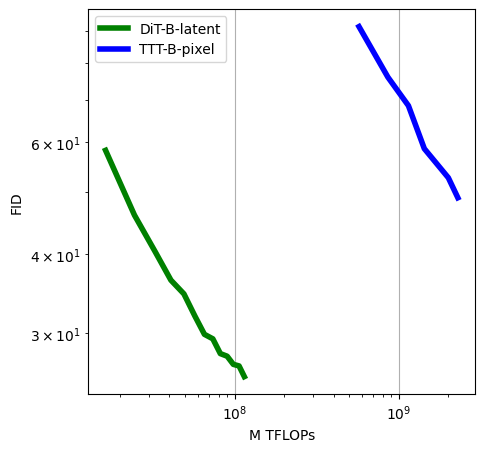

In [216]:
import re
# pixel_pattern = "TTT-(S|B)-pixel"
pixel_pattern = "TTT-B-pixel"
# latent_pattern = "DiT-(S|B|L)-latent"
latent_pattern = "DiT-B-latent"

plt.figure(figsize=(5, 5))
min_flops, max_flops = None, None
for k, v in data.items():
    if not (re.match(pixel_pattern, k) or re.match(latent_pattern, k)):
        continue
    print(k)
   
    if "-Ti-"  in k:
        linewidth = 1
    elif "-S-" in k:
        linewidth = 2
    elif "-B-" in k:
        linewidth = 4
    elif "-L-" in k:
        linewidth = 8
    elif "-XL-" in k:
        linewidth = 10
    else:
        raise ValueError(k) 
    
    if "latent" in k:
        linecolor = 'g'
    elif "pixel" in k:
        linecolor = 'b'
    else:
        raise ValueError(k)
    
    plt.plot(
        v['tflops'], v['fid'], 
        color=linecolor, linewidth=linewidth, label=k)
    
    min_flops = min(min_flops, v['tflops'].min()) if min_flops is not None else v['tflops'].min()
    max_flops = max(max_flops, v['tflops'].max()) if max_flops is not None else v['tflops'].max() 
   
multiple = 1000
xflops = jnp.linspace(min_flops, max_flops * 100, 1000)

# print("DiT")
# print(dit_params)
# latent_scaling_fids = dit_model.apply(dit_params, xflops)
# plt.plot(xflops, latent_scaling_fids, label="Latent Trend", 
#          c="r", linestyle="dashed")
# 
# print("TTT")
# print(ttt_params)
# pixel_scaling_fids = ttt_model.apply(ttt_params, xflops)
# plt.plot(xflops, pixel_scaling_fids, label="PIxel Trend", 
#          c="r", linestyle="dashed")
# 
plt.legend()
plt.xlabel('M TFLOPs')
plt.ylabel('FID')
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.show()

In [217]:
import re
def compute_scaling_trend(data, model_type):

    scaling_data = {}
    max_flops = 0
    fid_models = {}
    for name in data.keys():
        if not re.match(model_type, name):
            continue
        print(name)
        xs, ys, zs = make_data(name)
        if len(xs) == 0:
            continue    
        params, fid_model, eq = create_fid_model(xs, ys, verbose=False)
        print(eq)
        flops_per_iter = data[name]["tflops"][0] / float(data[name]["ckpt"][0])
        max_flops = max(max_flops, flops_per_iter * 4_000_000)
        
        fid_models[name] = {
            "params": params,
            "fid_model": fid_model,
            "eq": eq,
            "xs": xs,
            "ys": ys,
            "zs": zs,
            "flops_per_iter": flops_per_iter,
        }
        
    for name, model_info in fid_models.items(): 
        xs_ = jnp.linspace(1, max_flops * 5, 10_000)
        ys_ = model_info["fid_model"].apply(
            model_info["params"], xs_ / model_info["flops_per_iter"])
        
        scaling_data[name] = {
            "eq": model_info["eq"],
            "params": model_info["params"],
            "fid_model": model_info["fid_model"],
            "flops_per_iter": model_info["flops_per_iter"],
            "flops_est": xs_, "fid_est": ys_,
            "flops_orig": model_info["zs"],
            "fid_orig": model_info["ys"],
            "step_orig": model_info["xs"],
        }
    
    npnts = 100_000
    xs_flops = jnp.linspace(max_flops * 1e-5, max_flops * 10, npnts)
    ys_lst = min_flop_to_fid_curve(scaling_data, xs_flops)
    ys = ys_lst.min(axis=0)
    s_params, scaling_model, eq = create_fid_model(xs_flops, ys, verbose=False)
    print("="*40)
    print("Scaling trend: %s" % eq)
    print("="*40)
    return s_params, scaling_model, eq, scaling_data, max_flops



In [218]:
ttt_params, ttt_model, ttt_eq, ttt_scaling_data, max_flops = compute_scaling_trend(data, pixel_pattern)

TTT-B-pixel
[[-0.44800833]] [9.6721325]
(Before) Objective function:  0.00057662796
(Final) Objective function:  0.00029672624
Equation: F(C) = 4.5113 + 22158.44 * C ^ {-0.48}
F(C) = 4.5113 + 22158.44 * C ^ {-0.48}
[[-0.34598994]] [11.243246]
(Before) Objective function:  0.008196725
(Final) Objective function:  4.272634e-11
Equation: F(C) = 4.5108 + 1423568.50 * C ^ {-0.48}
Scaling trend: F(C) = 4.5108 + 1423568.50 * C ^ {-0.48}


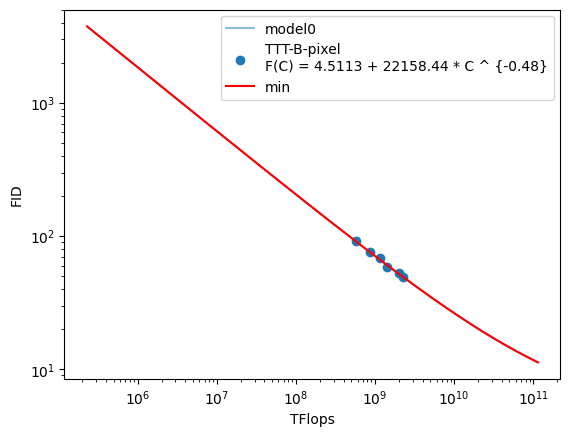

In [219]:

npnts = 100_000
xs_flops = jnp.linspace(max_flops * 1e-5, max_flops * 5, npnts)
ys_lst = min_flop_to_fid_curve(ttt_scaling_data, xs_flops)
for i in range(ys_lst.shape[0]):
    plt.plot(xs_flops, ys_lst[i], alpha=0.5, label=f"model{i}")
for name, scale_info in ttt_scaling_data.items():
    plt.scatter(
        scale_info["flops_orig"], scale_info["fid_orig"], label=f"{name}\n{scale_info['eq']}")
plt.plot(xs_flops, ys_lst.min(axis=0), c="r", label="min")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("TFlops")
plt.ylabel("FID")
plt.legend()


In [209]:
dit_params, dit_model, dit_eq, dit_scaling_data, max_flops = compute_scaling_trend(data, latent_pattern)
dit_scaling_data.keys()

DiT-B-latent
[[-0.40704748]] [8.687253]
(Before) Objective function:  0.0019585409
(Final) Objective function:  0.00011061463
Equation: F(C) = 18.1039 + 716676.62 * C ^ {-0.85}
F(C) = 18.1039 + 716676.62 * C ^ {-0.85}
[[-0.09447387]] [4.9894466]
(Before) Objective function:  0.0069145397
(Final) Objective function:  9.2771365e-14
Equation: F(C) = 18.1039 + 54732092.00 * C ^ {-0.85}
Scaling trend: F(C) = 18.1039 + 54732092.00 * C ^ {-0.85}


dict_keys(['DiT-B-latent'])

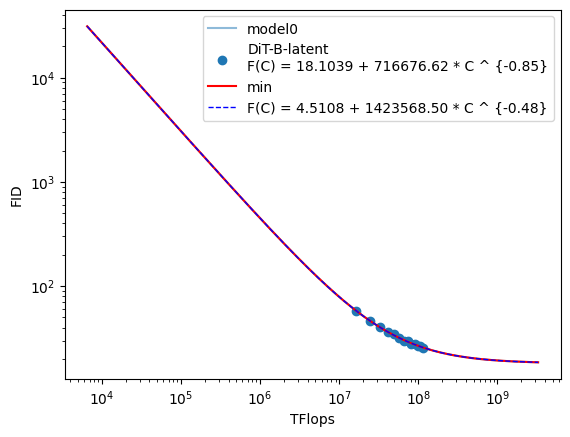

In [205]:
npnts = 100_000
xs_flops = jnp.linspace(max_flops * 1e-5, max_flops * 5, npnts)
ys_lst = min_flop_to_fid_curve(dit_scaling_data, xs_flops)
for i in range(ys_lst.shape[0]):
    plt.plot(xs_flops, ys_lst[i], alpha=0.5, label=f"model{i}")
for name, scale_info in dit_scaling_data.items():
    plt.scatter(
        scale_info["flops_orig"], scale_info["fid_orig"], label=f"{name}\n{scale_info['eq']}")
plt.plot(xs_flops, ys_lst.min(axis=0), c="r", label="min")

# Plot scaling trend prediction
ys_ = dit_model.apply(dit_params, xs_flops)
plt.plot(xs_flops, ys_, c="b", label=ttt_eq, linewidth=1, linestyle="dashed")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("TFlops")
plt.ylabel("FID")
plt.legend()

DiT-B-latent
TTT-B-pixel
DiT
{'params': {'alpha': Array([-0.16173108], dtype=float32), 'l_inf': Array([2.8961256], dtype=float32), 'scale': Array([17.81796], dtype=float32)}}
TTT
{'params': {'alpha': Array([-0.73139316], dtype=float32), 'l_inf': Array([1.5064669], dtype=float32), 'scale': Array([14.168677], dtype=float32)}}


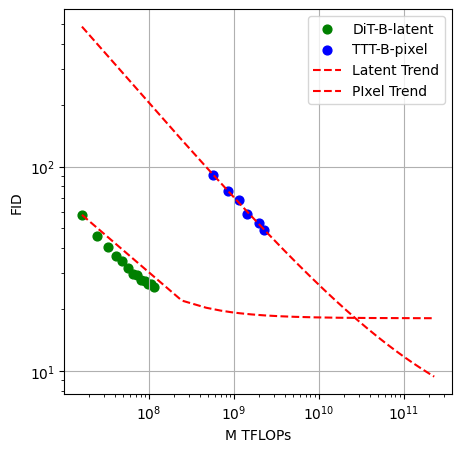

DiT-B-latent
TTT-B-pixel
DiT
dict_keys(['DiT-B-latent'])
TTT
{'params': {'alpha': Array([-0.73139316], dtype=float32), 'l_inf': Array([1.5064669], dtype=float32), 'scale': Array([14.168677], dtype=float32)}}


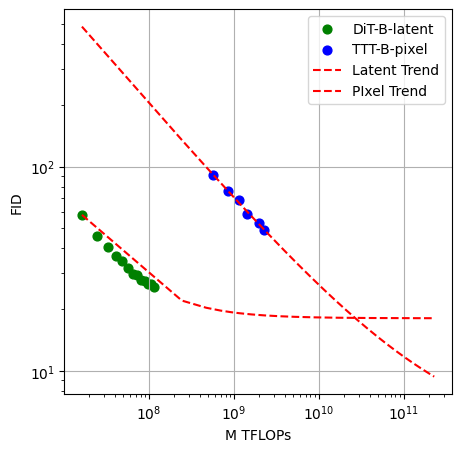

In [213]:

plt.figure(figsize=(5, 5))
min_flops, max_flops = None, None
for k, v in data.items():
    if not (re.match(pixel_pattern, k) or re.match(latent_pattern, k)):
        continue
    print(k)
   
    if "-Ti-"  in k:
        linewidth = 1
    elif "-S-" in k:
        linewidth = 2
    elif "-B-" in k:
        linewidth = 4
    elif "-L-" in k:
        linewidth = 8
    elif "-XL-" in k:
        linewidth = 10
    else:
        raise ValueError(k) 
    
    if "latent" in k:
        linecolor = 'g'
    elif "pixel" in k:
        linecolor = 'b'
    else:
        raise ValueError(k)
    
    plt.scatter(
        v['tflops'], v['fid'], 
        color=linecolor, s=linewidth * 10, label=k)
    # plt.plot(
    #     v['tflops'], v['fid'], 
    #     color=linecolor, linewidth=linewidth, label=k)
    
    min_flops = min(min_flops, v['tflops'].min()) if min_flops is not None else v['tflops'].min()
    max_flops = max(max_flops, v['tflops'].max()) if max_flops is not None else v['tflops'].max() 
   
multiple = 1000
xflops = jnp.linspace(min_flops, max_flops * 100, 1000)

print("DiT")
print(dit_scaling_data.keys())
latent_scaling_fids = dit_scaling_data["DiT-B-latent"]["fid_model"].apply(
    dit_scaling_data["DiT-B-latent"]["params"], 
    xflops / dit_scaling_data["DiT-B-latent"]["flops_per_iter"])
plt.plot(xflops, latent_scaling_fids, label="Latent Trend", 
         c="r", linestyle="dashed")

print("TTT")
print(ttt_params)
pixel_scaling_fids = ttt_scaling_data["TTT-B-pixel"]["fid_model"].apply(
    ttt_scaling_data["TTT-B-pixel"]["params"], 
    xflops / ttt_scaling_data["TTT-B-pixel"]["flops_per_iter"])
plt.plot(xflops, pixel_scaling_fids, label="PIxel Trend", 
         c="r", linestyle="dashed")

plt.legend()
plt.xlabel('M TFLOPs')
plt.ylabel('FID')
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.show()